In [86]:
%reload_ext autoreload
%autoreload 2

import numpy as np 
from sklearn.metrics import roc_auc_score

from utils import dist, normIt
from method import _robust_thres
from dataloader import dataLoader, _load_data_with_outliers

In [5]:
setIndex = 0
featureType = 'ResNet' 
all_feats, all_labels, dataset_name = dataLoader(setIndex, featureType)
dataset_name

feature type:  ResNet


'STL-10'

In [116]:
ind = 8 # inlier class
gamma = 0.4 # anomaly ratio

data, gt = _load_data_with_outliers(all_feats, all_labels, ind, gamma) # build target datset

## 1. Initial Outlier Score Function

In [117]:
data_norm = normIt(data)
score = dist(data_norm)   

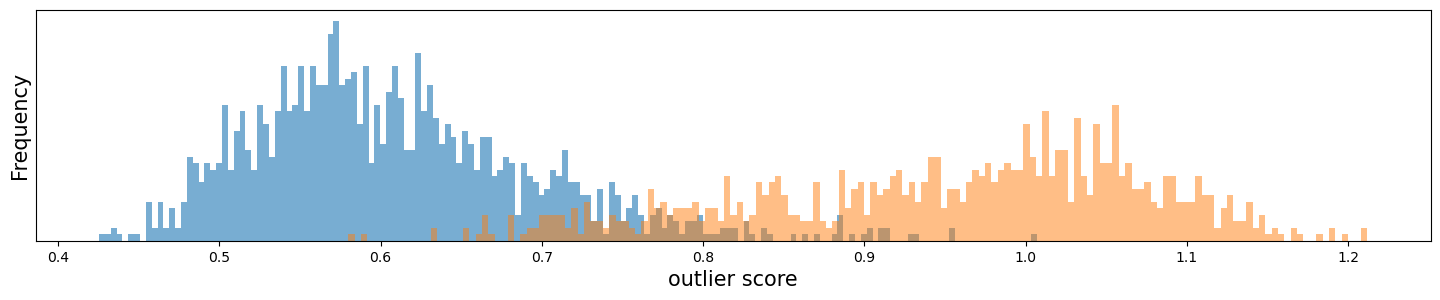

In [118]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (18, 3))

plt.hist(score[gt==0], bins = 160, alpha= 0.6, label = 'inlier')
plt.hist(score[gt==1], bins = 160, alpha= 0.5, label = 'outlier')

plt.xlabel('outlier score', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.yticks([])

plt.show()

## 2. Multi-thesholding (Our method)

In [119]:
hard_thres, soft_thres = _robust_thres(data)
hard_thres, soft_thres

(0.7473725154995918, 0.6844612233763545)

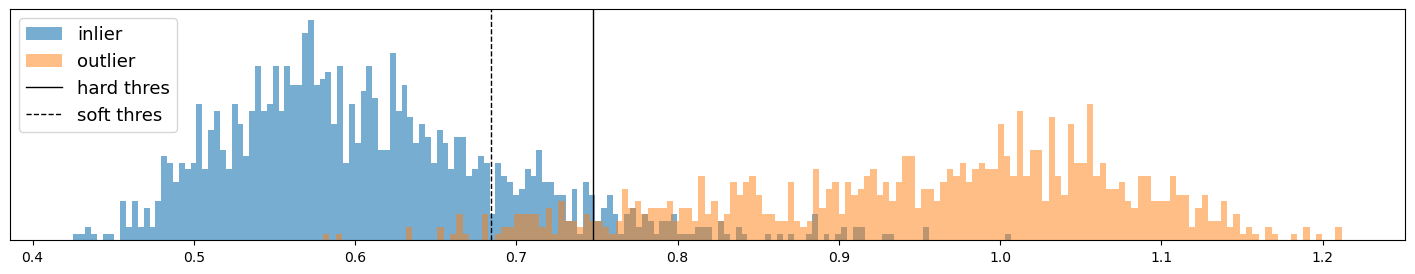

In [120]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (18, 3))
ax = plt.subplot(111)

plt.hist(score[gt==0], bins = 160, alpha= 0.6, label = 'inlier')
plt.hist(score[gt==1], bins = 160, alpha= 0.5, label = 'outlier')

plt.axvline(hard_thres, ymin = 0, ymax = 1, color="black", linestyle="-", linewidth = 1, label = 'hard thres') 
plt.axvline(soft_thres, ymin = 0, ymax = 1, color="black", linestyle="--", linewidth = 1, label = 'soft thres')

plt.legend(loc = 'upper left', prop={'size': 13})

# plt.xticks([])
plt.yticks([]) 
plt.show()

## 3. Enhancing current method

In [121]:
from sklearn.svm import OneClassSVM

# Default OCSVM
clf = OneClassSVM(gamma = 'auto').fit(data)
score_default = -clf.score_samples(data)

print('default ocsvm auc: ', format(roc_auc_score(gt, score_default), '.3f'))

default ocsvm auc:  0.833


In [122]:
clf = OneClassSVM(gamma = 'auto').fit(data_norm)
score_ergo = -clf.score_samples(data_norm)

print('ergodic-set normalized ocsvm auc: ', format(roc_auc_score(gt, score_ergo), '.3f'))

ergodic-set normalized ocsvm auc:  0.886


In [123]:
# anomalous data
anon = data[score>hard_thres]
# shell normalization
t = np.mean(anon, axis = 0)
data_norm = normIt(data, t)

# normal data
nor = data[score<soft_thres]
nor_norm = normIt(nor, t)

# OCSVM score
clf = OneClassSVM(gamma = 'auto').fit(nor_norm)
score_advanced = -clf.score_samples(data_norm)

print('advanced ocsvm auc: ', format(roc_auc_score(gt, score_advanced), '.3f'))

advanced ocsvm auc:  0.995
